<h1><center><b>Machine Learning</></center></h1>
<h4><center>89-511</center></h4>
<h3><center>Exercise 3</center></h3>
<h4><center>Submission date: 6/12/2022</center></h4>

Your Name:  
<font color='red'>
Osher Elhadad, 318969748
</font>


____________

In this exercise we will learn to:
1. Load, prepare and visualize datasets.
2. Implement Perceptron and train it.
3. Implement regularization.

**Instructions:**
- Create a copy of this notebook and implement your code in it.
- Download the dataset from [here](https://drive.google.com/file/d/1B3KrnISPjPrLzYZySUaY9q-imDBPqLWO/view?usp=sharing). (dataset.csv)
- Make sure you don't leave empty cells or empty answers.
- When you finish the assignment, download the notebook and submit it to the [**"submit"**](https://submit.cs.biu.ac.il/cgi-bin/welcome.cgi) system. 
To Download the notebook go to **"File"** -> **"Download .ipynb"**.  
- **Submit the notebook named 'perceptron.ipynb'**

### **1. Introduction to Colab and Numpy**

We use the Python programming language for all assignments in this course with the help of popular packages (like numpy, matplotlib, sklearn, scipy and pytorch).

Go over this **[numpy tutorial](https://cs231n.github.io/python-numpy-tutorial/)** before starting this assignment and **[this notebook](https://colab.research.google.com/github/cs231n/cs231n.github.io/blob/master/python-colab.ipynb)** to understand how to work with basic packages and with Google Colab. It is important to go over them before starting this assignment.

### **2. Setup**
Before running code on Colab:
- Check your Python version at the command line by running "!python --version". It should be Python 3.6 by default.
- Upload all files of this assignment (code and datasets) to your Drive (e.g "machine_learning_intro/assignments/assignment1") and mount that data to the machine. See the next cells below.  
In principle, it is also possible to upload files to the local disk of the colab machines, but such files will be deleted when the machine is restarted (not an often event).

In [1]:
# check python version
!python --version

Python 3.8.15


In [2]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the code and datasets.
# Recommended path: 'machine_learning_intro/assignments/assignment1/'
FOLDERNAME = 'machine_learning_intro/'
ASSIGNMENTNAME = 'assignment1'

%cd drive/My\ Drive
%cp -r $FOLDERNAME/$ASSIGNMENTNAME ../../
%cd ../../

Mounted at /content/drive
/content/drive/My Drive
/content


### **3. Dataset & Preprocessing**

In this section, we are going to load a 2-dimensional  data and preprocess it using the "numpy" package.  

In [3]:
# Load numpy package
import numpy as np

Load the pre-generated data provided to you. Using numpy, load the file "dataset.csv" and print its shape. You should see that the data is a numpy array (a matrix) with 500 rows (called **data samples**) and 3 columns. The first two columns are the **features** of the samples and the last column is the **label** of each sample.

In [4]:
# load data using "np.genfromtxt"
data = np.genfromtxt(f"{ASSIGNMENTNAME}/dataset.csv", delimiter=',',dtype=np.float64)
# print 5 rows from the data
print(data[:5])
# print its shape
print("Data shape:", data.shape)

[[ 1.75111789 -1.25722467 -1.        ]
 [ 2.47513131  1.7817015   1.        ]
 [ 0.89051961 -1.60740181 -1.        ]
 [ 1.71910455 -1.91091876 -1.        ]
 [ 0.99335187  1.00259882  1.        ]]
Data shape: (500, 3)


Split the data into features and labels and print their shape. Be careful not to change the content of the data.

In [5]:
# split the data to features and labels
features = data[:,0:2]
labels = data[:,2]
# print their shape
print("Features Shape:", features.shape)
print("Labels Shape:", labels.shape)

Features Shape: (500, 2)
Labels Shape: (500,)


Count how many samples are from class **-1**, and how many to class **+1**. Use the variable ```labels```  from the previous cell.

In [6]:
class_pos_idx = np.where(labels == 1)[0]
class_neg_idx = np.where(labels == -1)[0]
print("Num samples for class -1:",len(class_neg_idx))
print("Num samples for class +1:",len(class_pos_idx))

Num samples for class -1: 254
Num samples for class +1: 246


We can now split the data into train and test. The train would be 80% of the total #samples. The rest will go for test-set. We can use ```train_test_split``` function from sklearn.

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=36)

### **4. Visualizations**

It is always recommended to plot the data (when possible) and see the decision boundaries of our trained models. Since our data is a 2d vector (two features), we can plot each sample as a point in a 2d space.  
Use ```matplotlib``` and plot a **[scatter](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html)** plot contains all the points. Make sure that samples of class -1 will be colored "blue" while samples of class +1 will be colored "red". (Read more about matplotlib [here](https://matplotlib.org/))

In [8]:
import matplotlib.pyplot as plt

In [9]:
class_pos_idx = np.where(labels == 1)[0]
features[class_neg_idx, -2].shape

(254,)

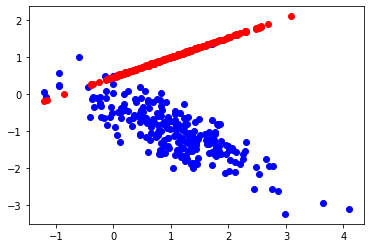

In [10]:
def plot_data(features, labels):
  '''
  The function plots the data on a 2d plane. It colors class -1 with the "blue" color 
  and class +1 with the "red" color.
  '''
  class_neg_idx = np.where(labels == -1)[0]
  class_pos_idx = np.where(labels == 1)[0]
  plt.scatter(features[class_neg_idx, -2], features[class_neg_idx, -1], color='blue')
  plt.scatter(features[class_pos_idx, -2], features[class_pos_idx, -1], color='red')


plot_data(features, labels)

### **5. Perceptron**

In this section, we  implement a Perceptron model using numpy. The perceptron aims to classify each sample to a class -1 or class +1 (binary classification task).

**Reminder:** The perceptron model takes an input vector $\mathbf{x}$. If the weighted sum of the inputs, $\mathbf{w}^T\mathbf{x}$ is greater than a threshold $b$ it outputs +1. Otherwise, it outputs a -1:
$$
    f(x)= 
\begin{cases}
    +1,& \text{if } \mathbf{w}^{T}\mathbf{x}\geq b\\
    -1,              & \text{otherwise}
\end{cases}$$

Remember that: $ \mathbf{w}^{T}\mathbf{x} = \sum_{i=1}^{n}{w_ix_i}$.


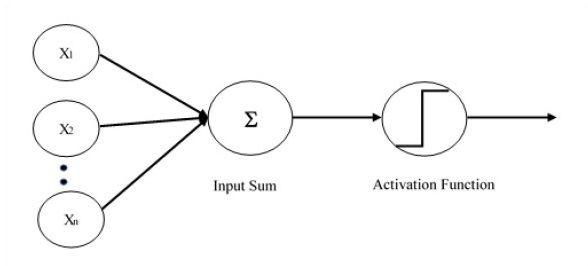

The main goal of the learning algorithm is to find  a vector  $\mathbf{w}$ capable of separating positive samples (y = +1) from negative (y = -1) samples.

To do that, we should learn two things: weights $\mathbf{w}$ and a bias term $b$. 

Instead of updating the bias separately, we can extend the input vector by appending a value of 1. The corresponding weight takes the role of the bias term. For this reason, we only update here the weight vector $\mathbf{w}$

**Learning $\mathbf{w}$:** (You have to write this code)

Start by initializing $\mathbf{w}$ randomly.  
$$
 \mathbf{w}^0 = \mathrm{a \, vector \,\,of \,\,small \,\,random \,\,values}
$$
When the model makes a mistake on a sample $\mathbf{x}_i$, then fix $\mathbf{w}$ using the update rule:

$$\mathbf{w}^{(t+1)} = \begin{cases}
    \mathbf{w}^{(t)},& \text{if   } y_i (\mathbf{w}^{(t)})^T\mathbf{x}_i > 0\\
    \mathbf{w}^{(t)} + \eta y_i \mathbf{x}_i,              & \text{otherwise}
\end{cases}$$

where $\eta$ is the learning rate. $\eta$ controls how much the weights change at each update.  

**Handle the bias term:**
We add a column of ones to the train and test features so we won't need to learn the bias. The train and test shapes will be (#samples,3). There are plenty of ways to do it. One way is using ```np.hstack``` function. 

In [11]:
def add_ones_column(X):
  # add a column of ones to the data
  ones_col = np.ones((X.shape[0],1))
  return np.hstack((ones_col,X))

X_train = add_ones_column(X_train)
X_test = add_ones_column(X_test)

Implement all methods of the Perceptron class below.

In [12]:
class Perceptron(object):
    def __init__(self, n_features, iterations=10, learning_rate=0.01):
        '''
        The function initialized the Perceptron model.
        n_features - number of features of each sample (excluding the bias)
        iterations - number of iterations on the training data
        learning_rate - learning rate, how much the weight will change during update
        '''
        self.iterations = iterations
        self.learning_rate = learning_rate
        np.random.seed(30) # set random seed, should not be altered!
        self.weights = np.random.randn(n_features + 1)
           
    def predict(self, input):
        '''
        The function makes a prediction for the given input.
        Output: -1 or 1.
        '''
        if np.dot(self.weights.T, input) >= 0:
          return 1
        else:
          return -1

    def evaluate(self, inputs, labels):
        '''
        The function makes a predictions for the given inputs and compares 
        against the labels (ground truth). It returns the accuracy.
        Accuracy = #correct_classification / #total
        '''
        correct_count = 0
        for i in range(len(inputs)):
          if self.predict(inputs[i]) == labels[i]:
            correct_count += 1
        return correct_count / len(labels)


    def train(self, training_inputs, train_labels, test_inputs, test_labels, verbose=True):
        '''
        The function train a perceptron model given training_inputs and train_labels.
        It also evaluates the model on the train set and test set after every iteration.
        '''
        for i in range(self.iterations):
            for x, y in zip(training_inputs, train_labels):
                if np.dot((y * self.weights.T), x) <= 0:
                  self.weights = self.weights + ((self.learning_rate * y) * x)
            if verbose:
              print(f"Iteration No.{i},\
               Train accuracy: {self.evaluate(training_inputs, train_labels)},\
                Test accuracy: {self.evaluate(test_inputs, test_labels)}")

Create a ```Perceptron``` instance and train it on the training data from before. For each iteration, print the train accuracy and test accuracy.  

You can set the hyperparamets to:  
iterations = 10  
learning_rate = 0.01.

In [13]:
model = Perceptron(2)
model.train(X_train, y_train, X_test, y_test)

Iteration No.0,               Train accuracy: 0.825,                Test accuracy: 0.82
Iteration No.1,               Train accuracy: 0.905,                Test accuracy: 0.91
Iteration No.2,               Train accuracy: 0.935,                Test accuracy: 0.97
Iteration No.3,               Train accuracy: 0.95,                Test accuracy: 0.97
Iteration No.4,               Train accuracy: 0.9525,                Test accuracy: 0.98
Iteration No.5,               Train accuracy: 0.9625,                Test accuracy: 0.99
Iteration No.6,               Train accuracy: 0.9625,                Test accuracy: 0.99
Iteration No.7,               Train accuracy: 0.9625,                Test accuracy: 0.99
Iteration No.8,               Train accuracy: 0.9625,                Test accuracy: 0.98
Iteration No.9,               Train accuracy: 0.9575,                Test accuracy: 0.98


### **6. Decision Boundary**

Let's visualize the decision boundary of the trained Perceptron. Use the function below for your plot.

In [14]:
def plot_decision_boundary(features, linear_model):
  '''
  Plots the decision boundary for a given linear model
  Inputs:
  features - numpy array with the data features, its shape should be (100,2)
  linear_model - trained model
  '''
  nb_col = []
  for i in range(X_train.shape[-1]):
    if not (X_train[:,i].min() == 1 and X_train[:,i].max()==1):
      nb_col.append(i)
      
  x_min, x_max = features[:, nb_col[0]].min() - .5, features[:, nb_col[0]].max() + .5
  y_min, y_max = features[:, nb_col[1]].min() - .5, features[:, nb_col[1]].max() + .5
  h = .02
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
  inputs = add_ones_column(np.c_[xx.ravel(), yy.ravel()])
  if "sklearn" in str(type(linear_model)):
    Z = linear_model.predict(inputs)
  else:
    Z = []
    for x in inputs:
      Z += [linear_model.predict(x)]
  Z = np.array(Z).reshape(xx.shape)
  plt.contour(xx, yy, Z, colors='k',linestyles=['-'])

Text(0.5, 1.0, 'Test')

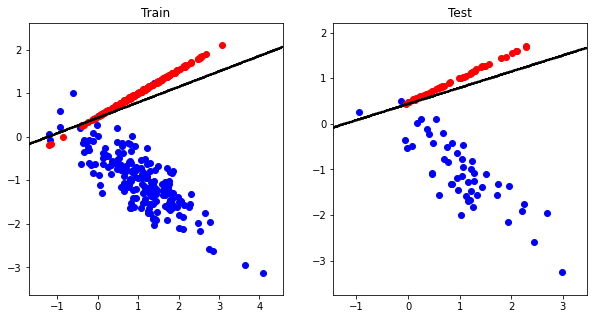

In [15]:
plt.rcParams['figure.figsize'] = 10, 5
plt.subplot(1,2,1)
# plot the training samples here
plot_data(X_train[:, 1:], y_train)
# use "plot_decision_boundary" above to plot the decision boundary of the Perceptron model
plot_decision_boundary(X_train, model)
plt.title("Train")

plt.subplot(1,2,2)
# plot the test samples here
plot_data(X_test[:, 1:], y_test)
# use "plot_decision_boundary" above to plot the decision boundary of the Perceptron model
plot_decision_boundary(X_test, model)
plt.title("Test")

**Q**: Can the perceptron model ever reach accuracy = 100% on the **training data**? Explain how if you think it's possible or why if you think it's not.

**A**: <font color='red'>
The perceptron model can't ever reach accuracy = 100% on the training data because all training data can't be linearly separated, as we can see in the training graph above, we can't draw a linear line that separates the red and blue dots because the dots are mixed together and the line we should draw to separate them is not linear. The perceptron model classifies the data by a linear line that is a decision boundary: inputs that are on one side of the separator line are classified as Class1, and inputs that are on the other side of the separator line are classified as Class2. We discovered that the training data can't be linearly separated, and the perceptron model classifies the data by a linear line, and therefore we can't get 100% accuracy on that data (there are few inputs that will be classified wrongly because those inputs are on the wrong side of the separator line). There are restrictions that a linear decision boundary cannot obey.
</font>


### **7. The effect of training-set size**

Let's investigate how the size of the training set affects the train and test accuracy.
We start by training our perceptron model on only 2 train samples, then on 5, 25, 50, 150, 250 and 400 samples.   
We evaluate all models on the test set.

In [16]:
train_samples = [2,5,25,50,150,250,400]

train_acc_ls, test_acc_ls = [], []

for train_size in train_samples:
  # randomly select `train_size` samples
  idx = np.random.choice(len(X_train), size=train_size, replace=False)
  small_X_train, small_y_train = X_train[idx], y_train[idx]
  # create and train a perceptron model
  model = Perceptron(n_features=2, iterations=100, learning_rate=0.01)
  model.train(small_X_train, small_y_train, X_test, y_test, verbose=False)
  # evaluate the model on train and test
  curr_train_acc = model.evaluate(small_X_train, small_y_train)
  curr_test_acc = model.evaluate(X_test, y_test)
  # keep track on it
  train_acc_ls += [curr_train_acc]
  test_acc_ls += [curr_test_acc]

  print(f"Train size: {train_size}, Train accuracy: {curr_train_acc}, Test accuracy: {curr_test_acc}")

Train size: 2, Train accuracy: 1.0, Test accuracy: 0.51
Train size: 5, Train accuracy: 1.0, Test accuracy: 0.8
Train size: 25, Train accuracy: 1.0, Test accuracy: 0.97
Train size: 50, Train accuracy: 1.0, Test accuracy: 0.97
Train size: 150, Train accuracy: 0.9666666666666667, Test accuracy: 0.98
Train size: 250, Train accuracy: 0.964, Test accuracy: 0.98
Train size: 400, Train accuracy: 0.9675, Test accuracy: 0.98


Text(0, 0.5, 'Accuracy')

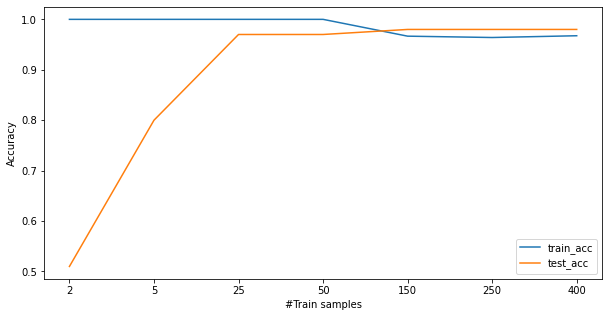

In [17]:
# plot train and test accuracy as a function of train size
train_samples = ["2","5","25","50","150","250","400"]
plt.plot(train_samples, train_acc_ls)
plt.plot(train_samples, test_acc_ls)
plt.legend(["train_acc","test_acc"])
plt.xlabel("#Train samples")
plt.ylabel("Accuracy")

**Q**: What can we learn from the plot above? What is the effect that occurs when we train a model on a very small train set? How does it affect the train and test accuracy?

**A**: <font color='red'>
Remind that the perceptron model can't ever reach accuracy = 100% on the training data because that all training data can't be linearly separated, as we can see in the plot in question 6 and explained there. We can learn from the plot above that first, when the train set has 50 and less samples the train accuracy is 100%, because the training data can be separated linearly, and therefore the model can find accurate decision boundary, a line that separates this training data to classes (2 classes - one on the first side of the line and one on the other side of the line) because the model has fewer samples - fewer restrictions on the decision boundary. When the train set has 150 and more we get like in question 6 training data that can't be separated linearly because of mixed samples that don't allow linear separation, and when we have these kinds of samples we will never (if the number of train samples gets higher) reach with a perceptron model to accuracy = 100%. Second we can learn from the plot above that the more samples we have in our training set, we will get a higher test accuracy because we get closed to the distribution of the all possible samples, and our model know more samples and is more accuracy because has more restrictions by samples and the model needs a more accurate decision boundary. We can see that the lower the number of train samples, the test accuracy's elevation rate is higher. The higher the test accuracy becomes, the elevation rate is lower (logarithmic). The effect that occurs when we train a model on a very small train set is kind of underfitting because we have a 100% accuracy rate on the training set, but our decision boundary is not accurate (has fewer restrictions, and fewer train samples) and doesn't have enough samples to create an accurate decision boundary. There are more options for creating decision boundaries (with fewer restrictions), so the possibility that the model will create an accurate decision boundary is lower, and therefore we get a lower accuracy rate on the test set. And as I explained above, when the number of train set is very small, the model has fewer samples, fewer restrictions on the decision boundary, and therefore 100% accuracy.
</font>


### **8. Regularization**

We wish to improve the test accuracy when training with little data. As discussed in class, overfitting can be reduced by adding a regularization term to the loss:

$$\hat{E}(w) = \sum_{i}{\mathrm{loss}_\mathbf{w}(h(x),y)} + \frac{\lambda}{2}||\mathbf{w}||^2$$

where $\lambda$ is the regularization coefficient (hyper parameter) and $||\mathbf{w}||^2$ is a L2 regularization.  
Reminder: $||\mathbf{w}||^2 = \sum_{i=1}^{k}{w_i^2}$

**Q**: What will be the new update rule when the loss includes regularization?  
Copy an image or write in [$latex$](https://colab.research.google.com/github/bebi103a/bebi103a.github.io/blob/master/lessons/00/intro_to_latex.ipynb)

**A**: <font color='red'>
**Learning $\mathbf{w}$:** (You have to write this code)

Start by initializing $\mathbf{w}$ randomly.  
$$
 \mathbf{w}^0 = \mathrm{a \, vector \,\,of \,\,small \,\,random \,\,values}
$$

we use no-margin hinge loss and add ${\frac {\lambda} {2}} {||w||^2}$, therefore:

$$\mathbf {loss_w}{(h(x), y)} = \begin{cases}
    \frac {\lambda} {2} ||w||^2,& \text{if   } y (\mathbf{w})^T\mathbf{x} > 0\\ - y (\mathbf{w})^T \mathbf{x} + \frac {\lambda} {2} ||w||^2,              & \text{otherwise}
\end{cases}$$

$$\mathbf {\nabla}{loss_w}{(h(x), y)} = \begin{cases}
    {\lambda} w,& \text{if   } y (\mathbf{w})^T\mathbf{x} > 0\\ - y \mathbf{x} + {\lambda} w,              & \text{otherwise}
\end{cases}$$

When the model makes a mistake on a sample $\mathbf{x}_i$, then fix $\mathbf{w}$ using the update rule ($\eta$ multiply by the gradient of the loss:

$$\mathbf{w}^{(t+1)} = \begin{cases}
    \mathbf{w}^{(t)} - \eta \lambda {w}^{(t)},& \text{if   } y_i (\mathbf{w}^{(t)})^T\mathbf{x}_i > 0\\
    \mathbf{w}^{(t)} + \eta y_i \mathbf{x}_i - \eta \lambda {w}^{(t)},              & \text{otherwise}
\end{cases}$$

Where $\eta$ is the learning rate. $\eta$ controls how much the weights change at each update.

And $\lambda$ is the regularization coefficient (hyper parameter).
</font>


Implement the Perceptron algorithm again but with regularization. All functions should be the same from the previous section except the ``train`` function.  
**Important: Don't regularize the bias term ($\mathbf{w}_0$).**

In [18]:
class RegularizedPerceptron(object):
    def __init__(self, n_features, lambda_value, iterations=10, learning_rate=0.01):
        '''
        The function initialized the Perceptron model.
        n_features - number of inputs to the perceptron (excluding the bias)
        iterations - number of iterations on the training data
        learning_rate - learning rate, how much the weight will change during update
        '''
        self.iterations = iterations
        self.learning_rate = learning_rate
        np.random.seed(30) # set random seed, should not be altered!
        self.weights = np.random.randn(n_features + 1)
        self.lambda_value = lambda_value
           
    def predict(self, inputs):
        '''
        The function makes a prediction for the given inputs.
        Output: -1 or 1.
        '''
        if np.dot(self.weights.T, inputs) >= 0:
          return 1
        else:
          return -1

    def evaluate(self, inputs, labels):
        '''
        The function makes a predictions for the given inputs and compares 
        against the labels (ground truth). It returns the accuracy.
        Accuracy = #correct_classification / #total
        '''
        correct_count = 0
        for i in range(len(inputs)):
          if self.predict(inputs[i]) == labels[i]:
            correct_count += 1
        return correct_count / len(labels)

    def train(self, training_inputs, train_labels, test_inputs, test_labels, verbose=True):
        '''
        The function train a perceptron model given training_inputs and train_labels.
        It also evaluates the model on the train set and test set after every iteration.
        '''
        for i in range(self.iterations):
            for inputs, label in zip(training_inputs, train_labels):
              self.weights[1:] = self.weights[1:] - ((self.learning_rate * self.lambda_value) * self.weights[1:])
              if np.dot((label * self.weights.T), inputs) <= 0:
                self.weights = self.weights + ((self.learning_rate * label) * inputs)
            if verbose:
              print(f"Iteration No.{i},\
               Train accuracy: {self.evaluate(training_inputs, train_labels)},\
                Test accuracy: {self.evaluate(test_inputs, test_labels)}")

Let's compare ```RegularizedPerceptron``` against our regular ```Perceptron``` on a trainset with 5 samples.

In [19]:
# set lambda value
lambda_value = 0.4

In [20]:
train_size = 5

# randomly select `train_size` samples
idx = np.random.choice(len(X_train), size=train_size, replace=False)
small_X_train, small_y_train = X_train[idx], y_train[idx]

# create and train a perceptron model
perceptron = Perceptron(n_features=2, iterations=100, learning_rate=0.01)
perceptron.train(small_X_train, small_y_train, X_test, y_test, verbose=False)

# evaluate the model on train and test
print(f"Perceptron: Train Acc: {perceptron.evaluate(small_X_train, small_y_train)},\
 Test Acc: {perceptron.evaluate(X_test, y_test)}")


# create and train a regularized perceptron model
reg_perceptron = RegularizedPerceptron(n_features=2, lambda_value = lambda_value,
                                       iterations=100, learning_rate=0.01)
reg_perceptron.train(small_X_train, small_y_train, X_test, y_test, verbose=False)

# evaluate the model on train and test
print(f"RegularizedPerceptron: Train Acc: {reg_perceptron.evaluate(small_X_train, small_y_train)},\
 Test Acc: {reg_perceptron.evaluate(X_test, y_test)}")


Perceptron: Train Acc: 1.0, Test Acc: 0.8
RegularizedPerceptron: Train Acc: 1.0, Test Acc: 0.81


We arbitrarily chose $\lambda = 0.4$ and increased the test accuracy by 1%. We can probably do better.    
Do a hyperparameter search (over 10 possible values) to find a lambda value that gives the best test accuracy.  
(Note: Usually, hyperparameter search is done on a validation set, since the data is small we do it here on the test set).

In [28]:
# find best lambda value
# For lambda_value in [...]: train and evaluate RegularizedPerceptron.
# Find model with highest accuracy
first_lambda = 0.1

# create and train a regularized perceptron model
reg_perceptron = RegularizedPerceptron(n_features=2, lambda_value = first_lambda,
                                       iterations=100, learning_rate=0.01)
reg_perceptron.train(X_train, y_train, X_test, y_test, verbose=False)

best_lambda = first_lambda
max_test_acc = reg_perceptron.evaluate(X_test, y_test)
train_acc = reg_perceptron.evaluate(X_train, y_train)
print('lambda: ' + str(best_lambda) + ' with train Acc: ' + str(train_acc) + ' and test Acc: ' + str(max_test_acc))
for lambda_value in range(2, 11):

  # create and train a regularized perceptron model
  reg_perceptron = RegularizedPerceptron(n_features=2, lambda_value = lambda_value / 10,
                                       iterations=100, learning_rate=0.01)
  reg_perceptron.train(X_train, y_train, X_test, y_test, verbose=False)
  new_test_acc = reg_perceptron.evaluate(X_test, y_test)
  new_train_acc = reg_perceptron.evaluate(X_train, y_train)
  print('lambda: ' + str(lambda_value / 10) + ' with train Acc: ' + str(new_train_acc) + ' and test Acc: ' + str(new_test_acc))
  if new_test_acc > max_test_acc:
    best_lambda = lambda_value / 10
    max_test_acc = new_test_acc
    train_acc = new_train_acc

print('The best lambda is: ' + str(best_lambda) + ' with train Acc: ' + str(train_acc) + ' and test Acc: ' + str(max_test_acc))

lambda: 0.1 with train Acc: 0.965 and test Acc: 0.98
lambda: 0.2 with train Acc: 0.965 and test Acc: 0.98
lambda: 0.3 with train Acc: 0.965 and test Acc: 0.98
lambda: 0.4 with train Acc: 0.965 and test Acc: 0.98
lambda: 0.5 with train Acc: 0.965 and test Acc: 0.98
lambda: 0.6 with train Acc: 0.965 and test Acc: 0.98
lambda: 0.7 with train Acc: 0.9675 and test Acc: 0.98
lambda: 0.8 with train Acc: 0.9675 and test Acc: 0.98
lambda: 0.9 with train Acc: 0.97 and test Acc: 0.99
lambda: 1.0 with train Acc: 0.97 and test Acc: 0.99
The best lambda is: 0.9 with train Acc: 0.97 and test Acc: 0.99


**Q**:What is the best $\lambda$ you found? What is the train and test accuracy for that model?

**A**: <font color='red'>
The best lambda I found is: 0.9 with train Acc: 0.97 and test Acc: 0.99
</font>
